In [41]:
%matplotlib widget
import casadi as ca
import numpy as np
from src.opti_mpc_utils import plot_results 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.close("all")


# Create an Opti instance
opti = ca.Opti()

# Solver options
p_opts = {
    "expand":True,
    #"qpsol": "ipopt",
    #"convexify_strategy": "regularize",
    "print_time": 0,
    #"print_iteration": 0,
    #"print_header": 0,
    "verbose": False,
    "error_on_fail": False
}
s_opts = {}
opti.solver("ipopt",p_opts,
                    s_opts)

#=========== Define the Horizon ============
N = 200 # 1min
Ts = 5  


#============= Tank Model ==================
# x = [Qin, h, Qout]
# y = [h, Qout]
A = 18
F = np.array([[1,0,0],[Ts/A,1,-Ts/A],[0, 0, 1]])
C = np.array([[0,1,0],[0, 0, 1]])



#=========== Parameters of the static models
# B1_power = np.array([[2.8481E-02,0,0],[0,3.3614E-02,0],[0,0,1.7562E-02]])
# B2_power = np.array([[1.6230E-05,0,0],[0,5.1395E-05,0],[0,0,2.7402E-05]])
# C_power = np.array([[7.4287E-02],[1.0755E+00],[7.6364E-02]])


B1_pressure = np.array([9.2727E-05])
B2_pressure = np.array([2.5979E-08])
C_pressure = np.array([5.3955E-01])

zs = 3;

#=========== Parameters of the ARX model
# array of params
A_outflow = np.array([1.1493E-01, 3.5884E-07, -2.9890E-07, -8.4661E-02, 7.5640E-04,
                    -3.8695E-04, 3.9287E-04, -6.8566E-07, -1.5757E-04, 1.0592E-03,
                    2.7095E-07, -4.1301E-01, 7.0157E-05]).reshape((1,-1))

A_power = np.hstack([np.diag([1.6108E-01, 3.6872E-03, 2.3590E-01]), np.diag([9.5030E-02, 3.1648E-03, 1.9355E-01])])
# A_pressure = 5.5858E-05


B_power = np.diag([3.5117E-02, 4.1216E-02, 2.7095E-02])
# B_pressure = 5.3294E-01

C_power = np.array([0, 0, 1.5144E-03]).reshape((3,-1))
# C_pressure = 2.5055E-01




#=========== Desired value of y 
Qout_meas = opti.parameter(zs)   # ascending index: older data, at 0: last measured value (t-1)
Qin_est = opti.parameter(N+zs)
h_ref = opti.parameter(N+zs)
w_meas =  opti.parameter(3,zs)   #TODO: Remove hard-coded Dims

h_meas = opti.parameter(zs)
E_meas = opti.parameter(3,zs)
P_meas = opti.parameter(zs)

trigger = opti.parameter(3) # Trigger constant over entire horizon

#=========== Declare Symbolic Variables
Qout = opti.variable(N+zs)
Qin = opti.variable(N+zs)
E = opti.variable(3,N+zs)
P = opti.variable(N+zs)
w = opti.variable(3,N+zs)
h = opti.variable(N+zs)
effi = opti.variable(N+zs)

#============= Slack Variables
s_h = opti.variable(N+zs)
s_P = opti.variable(N+zs)
s_w = opti.variable(3) # Trigger slack constant over entire horizon

Qin[:] = Qin_est


#=========== Objective function
objective = 0

for t in range(zs, N+zs):
    dw = w[:,t]-w[:,t-1]
    # objective += 0.05*((E[:,t].T @ E[:,t])/(Qout[t]+0.0001))**2    +   0.01 *((dw.T)@ dw)   +  10*(h[t]-h_ref[t])**2 + 10*s_h[t] + 10*s_P[t] + 1*(s_w[t].T @ s_w[t])
    objective += 0.0 *((dw.T)@ dw)   +  0.01*(h[t]-h_ref[t])**2 + 1000*s_h[t]**2 + 10*s_P[t]**2 + 0.001*(s_w[:].T @ s_w[:])
    # objective += 10*(h[t]-h_ref[t])**2 + 10*s_h[t]

opti.minimize(objective)   


# ARX model constraints
for t in range(zs, N+zs):   
    opti.subject_to(Qout[t] ==ca.if_else( 
                                w[0,t-1] <= 600,
                                3.2216 + 0.08378681 * w[0,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[0,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True) 
                            + ca.if_else(
                                w[1,t-1] <= 600,
                                3.2216 + 0.08378681 * w[1,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[1,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True)
                            + ca.if_else(
                                w[2,t-1] <= 600,
                                3.2216 + 0.08378681 * w[2,t-1],  # First segment equation
                                3.22 + 0.083 * 600 + 0.8371 * (w[2,t-1] - 600),  # Second segment equation, ensuring continuity at the breakpoint
                                True))


    opti.subject_to(E[:,t] == A_power @ ca.vcat([E[:,t-1],E[:,t-2]]) + B_power @ w[:,t-1] + C_power)

    opti.subject_to(P[t] == B1_pressure @ Qout[t] + B2_pressure @ Qout[t]**2 + C_pressure) 
      
    opti.subject_to(h[t] == h[t-1] + Ts/3600*(Qin[t-1]-Qout[t-1])/A)

for t in range(0, N+zs):
    opti.subject_to(effi[t] == E[:,t].T @ E[:,t]/(Qout[t]+0.0001))



# Additional constraints (e.g., on control input)
for t in range(zs, N+zs):
    opti.subject_to(w[:,t] >= 0)  # Lower bound on control input
    
    opti.subject_to(w[:,t] <= ca.fmin(1500*trigger[:]+s_w[:],1500))
    # opti.subject_to(w[0,t] <= ca.fmin(1500*trigger[0,t],1500))
    # opti.subject_to(w[1,t] <= ca.fmin(1500*trigger[1,t],1500))
    # opti.subject_to(w[2,t] <= ca.fmin(1500*trigger[2,t],1500))

    # opti.subject_to(w[0,t] <= 1500)
    # opti.subject_to(w[1,t] <= 0)
    # opti.subject_to(w[2,t] <= 0)

    opti.subject_to(h[t] <= (200 + s_h[t]))
    opti.subject_to(h[t] >= (120 - s_h[t]))
    opti.subject_to(P[t] <= (1 + s_P[t]))  # upper bound on pressure

    # Slack Variables need to be constrained to positive values
    opti.subject_to(s_h[t] >= 0)
    opti.subject_to(s_P[t] >= 0)
    # opti.subject_to(s_w[:,t] >= 0)

opti.subject_to(s_w[:] >= 0)



# Initial conditions
opti.subject_to(Qout[0:zs]   == Qout_meas)  # Initial value of y, read from sensor
opti.subject_to(h[0:zs]      == h_meas)
opti.subject_to(w[:,0:zs]    == w_meas)  

opti.subject_to(P[0:zs]      == P_meas)
opti.subject_to(E[:,0:zs]      == E_meas)
    

# ===== Initalizing the KF =============
# x = [Qin, h, Qout]
# y = [h, Qout]
xhat_corr_hist = np.zeros((zs,3))

xhat_corr = np.array([300,150,500])
# xhat_pred = np.array([0,0,0])
Phat_corr = np.diag([0,0,0])
# Phat_pred = np.diag([0,0,0])

G_w = np.eye(3)
V = np.diag([0.001,0.001]) # Measurement Noise TODO: Measure on data
W = np.diag([0.01,0.1,0.01])   # Process Noise


# ==== Last element[-1]: latest; first[0]: oldest
h_hist = [150,151,152]
w_hist = np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)
Qout_hist = [317,316,315]
E_hist = np.vstack([[0,0,0],[0,0,0],[0,0,0]]).reshape(3,-1)
P_hist = [1,0.9,0.8]

for k in range(1):   

    # Update the following values:
    # - Qin_est
    # - Qout_meas
    # - E_meas
    # - P_meas
    # - w_meas
    # - h_meas

    # =================== Measurements ===================
    h_meas_k = 150
    h_hist = np.hstack([h_hist[1:], h_meas_k])

    w_meas_k = np.array([500,0,0]).reshape(3,-1)
    w_hist = np.hstack([w_hist[:,1:], w_meas_k])

    Qout_meas_k = 314
    Qout_hist = np.hstack([Qout_hist[1:], Qout_meas_k])   

    E_meas_k = np.array([0,20,30]).reshape(3,-1)
    E_hist = np.hstack([E_hist[:,1:], E_meas_k])   

    P_meas_k = 1.1
    P_hist = np.hstack([P_hist[1:], P_meas_k])   


    trigger_k = [1,0,0]

    h_ref_k = np.arange(150, 145, (145-150)/(N+zs))
    

    # =================== Kalman Filter ===================
    xhat_pred = F @ xhat_corr  # No input
    Phat_pred = F @ Phat_corr @ F.T +G_w @ W @ G_w.T # A propri covariance

    L = Phat_pred @ C.T @ np.linalg.inv(C @ Phat_pred @ C.T + V)

    y_k = np.array([h_meas_k,Qout_meas_k]) # Latest measurement at step k
    xhat_corr = xhat_pred + L @ (y_k - C @ xhat_pred)
    xhat_corr_hist[k] = xhat_corr
    Phat_corr = (np.eye(3)-L @ C) @ Phat_pred


    # opti.set_value(Qin_est,np.arange(1000, 3000, (3000-1000)/(N+zs)))   # TESTING ONLY
    opti.set_value(Qin_est,xhat_corr[0]) # NOTE: For single iteration, low value
    opti.set_value(Qout_meas,Qout_hist)
    opti.set_value(h_meas,h_hist)
    opti.set_value(w_meas,w_hist) 

    opti.set_value(E_meas,E_hist)
    opti.set_value(P_meas,P_hist)

    opti.set_value(trigger,trigger_k) # Select enabled pumps
    opti.set_value(h_ref,h_ref_k)


    
    try:
        sol = opti.solve();   # actual solve
    except:
        opti.debug.show_infeasibilities()


        # plot_results(opti.debug)
        print("################################ Solution not converged ################################")
        sol = opti.debug




This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     5242
Number of nonzeros in inequality constraint Jacobian.:     3403
Number of nonzeros in Lagrangian Hessian.............:     2624

Total number of variables............................:     2439
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1430
Total number of inequality constraints...............:     2203
        inequality constraints with only lower bounds:     1003
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:     1200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3502014e+04 5.00e+02 2.85e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

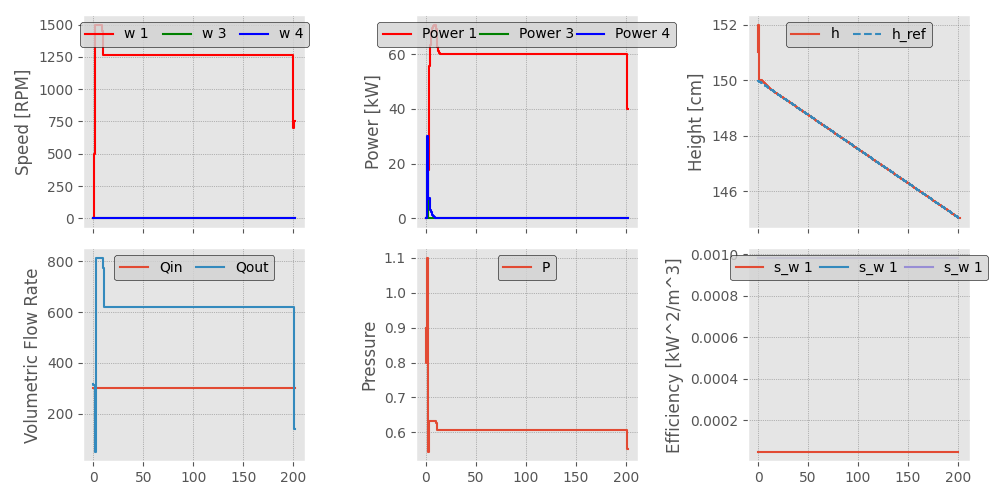

In [42]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# Plot 1 - Speed [RPM]
axs[0, 0].step(sol.value(w)[0, :], "r", label='w 1')
axs[0, 0].step(sol.value(w)[1, :], "g", label='w 3')
axs[0, 0].step(sol.value(w)[2, :], "b", label='w 4')
# axs[0, 0].set_ylim([0, 1700])
axs[0, 0].set_ylabel('Speed [RPM]')
axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# Plot 2 - Power [kW]
axs[0, 1].step(sol.value(E)[0, :], "r", label='Power 1')
axs[0, 1].step(sol.value(E)[1, :], "g", label='Power 3')
axs[0, 1].step(sol.value(E)[2, :], "b", label='Power 4')
axs[0, 1].set_ylabel('Power [kW]')
axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 1].set_ylim([0, 150])
axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 3 - Height
axs[0, 2].step(range(len(sol.value(h))), sol.value(h), label='h')
axs[0, 2].step(range(len(sol.value(h_ref))), sol.value(h_ref),"--", label='h_ref')
axs[0, 2].set_ylabel("Height [cm]")
axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 2].set_ylim([0, 250])
axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1, 0].step(range(len(sol.value(Qin))), sol.value(Qin), label='Qin')
axs[1, 0].step(range(len(sol.value(Qout))), sol.value(Qout), label='Qout')
axs[1, 0].set_ylabel("Volumetric Flow Rate")
axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 0].set_ylim([0, 800])
axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - Pressure
axs[1, 1].step(range(len(sol.value(P))), sol.value(P), label='P')
axs[1, 1].set_ylabel("Pressure")
axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 1].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 6 - effi
# axs[1, 2].step(range(len(sol.value(effi))), sol.value(effi), label='s_e 1')
# axs[1, 2].step(range(len(sol.value(s_h[:]))), sol.value(s_h[:]), label='s_h')
axs[1, 2].step([0,N],[sol.value(s_w[0]),sol.value(s_w[0])], label='s_w 1')
axs[1, 2].step([0,N],[sol.value(s_w[1]),sol.value(s_w[1])], label='s_w 1')
axs[1, 2].step([0,N],[sol.value(s_w[2]),sol.value(s_w[2])], label='s_w 1')
axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 2].set_ylabel("Efficiency [kW^2/m^3]")
# axs[1, 2].set_ylim([0, 1500])
axs[1, 2].legend(loc='upper center', columnspacing=0.5, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

plt.tight_layout()
plt.show()
